In [10]:
import os
import csv
import glob   
import netCDF4
import numpy as np        
import matplotlib as mpl    
import matplotlib.mlab as mlab     
import matplotlib.style as style
import matplotlib.pyplot as plt     # For plotting
import matplotlib.dates as mdates   # For formatting dates when plotting
import xarray as xr                 # For dealing with netCDF data
import cartopy.crs as ccrs          # For plotting maps
import cartopy.feature as cfeature  # For plotting maps
import pandas as pd                 # A quick way to deal with time stamps

import wrf
from wrf import (getvar, interplevel, vertcross, 
                 vinterp, ALL_TIMES, extract_global_attrs)
from netCDF4 import Dataset

print('Done')

Done


In [11]:
def wrf_unstagger( grid, dim ):
    """ Unstagger a staggered WRF grid in the X, Y, or Z (U, V, or W) direction.
        ---------------------
        grid (numpy.ndarray): The 2D, 3D, 4D, or 5D array to be unstaggered.
        dim (str): A string specifying what dimension to unstagger. Must be
        X, Y, Z, U, V or W.
        ---------------------
        returns:
        numpy.ndarray unstaggered grid (dim-1)
        ---------------------
        EXAMPLE:
        import numpy as np

        arr = np.random.randint( low=1, high=10, size=( 9,10,9 ) ) ## create a random array staggered in the Y direction
        arr_unstaggered = wrf_unstagger( arr, 'Y' )
        """
    nd = len( grid.shape )
    if dim == 'X' or dim == 'U':
        if nd == 4:
            gridout = ( grid[ :, :, :, :-1 ] + grid[ :, :, :, 1: ] ) / 2.
        else: pass
    if dim == 'Y' or dim == 'V':
        if nd == 4:
            gridout = ( grid[ :, :, :-1, : ] + grid[ :, :, 1:, : ] ) / 2.
        else: pass
    if dim == 'Z' or dim == 'W':
        if nd == 4:
            gridout = ( grid[ :, :-1, :, : ] + grid[ :, 1:, :, : ] ) / 2.
        else: pass
    return gridout



def wrf_pres(P,PB):
    return (P+PB) #in Pa

def wrf_height(PH,PHB):
    return (PH+PHB)/9.81

def wrf_theta(PTEMP):
    return (PTEMP+300.)

def wrf_temp(THETA,PRES):
    return (THETA)*(PRES/1000.)**(.2854) # in hPa


def wrf_rh(TEMP,PRES,MXRAT):
    A= 6.11*100. #Pa
    Rv = 461.495 #J/kg/K
    Lv = 2.453*10**6 #J/Kg
    
    ES = A*np.exp((Lv/Rv)*((1./273.)-(1./TEMP))) #in Pa
    SMXRAT = ((621.97*ES)/(PRES-ES))/1000.
    return (MXRAT/SMXRAT)*100.



def get_wrf_var(var,file_path):
    '''
    Requirements: 
    import netCDF4
    
    This function will read in a wrf file and the desired variable 
    The input is the variable name and the location of the file
    The output is an array of the desired variable in the native units
    example: get_wrf_var('PSFC','/location/to/file')    
    '''
    ncfile = netCDF4.Dataset(file_path,mode='r')
    ncvar = ncfile.variables[var][:]
    ncfile.close()
    return ncvar



def pres_interp(var,surface,new_height): 
    '''
    Takes a wrf variable like u,v,w, and/or mixing ratios and linearly interpolates it to pressure surfaces
    
    input: variable with 4D (time, height, x, y), the pressure surface as the same 4D variable, and the pressure
    levels that you want to interpolate to
    output: variable with 4D (time, new height, x, y)
    
    import numpy as np
    
    Note: np.interp requires the arrays to be increasing, so since we are interpolating to pressure coords
    we have to reverse the direction
    '''
    
    #######################
    #These are the pressure levels to interpolate to if you want to define them here
    #new_height = np.array([1000,850,700,500,200,100]) 
    #######################
    
    new_surf = np.empty((var.shape[0],new_height.shape[0],var.shape[2],var.shape[3]))

    for TIM in np.arange(var.shape[0]): #Loop over all the time periods
        for IDX, VAL in np.ndenumerate(var[0][0]): #Loop over all the points
            new_val = np.interp(new_height,surface[TIM,::-1,IDX[0],IDX[1]],var[TIM,::-1,IDX[0],IDX[1]], right=np.nan)
            new_surf[TIM,:,IDX[0],IDX[1]]=new_val[:] #put the interpolated profile into the new array
    return new_surf

In [12]:
WRF_DIRECTORY_NWF = "/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#13"
WRF_FILES_NWF = sorted([f for f in glob.glob(WRF_DIRECTORY_NWF+"/wrfout_d01_*")])
_WRF_FILES_NWF = [os.path.abspath(
                  os.path.join(WRF_DIRECTORY_NWF, f)) for f in WRF_FILES_NWF]
print(WRF_FILES_NWF)

['/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#13/wrfout_d01_2021-08-25_00:00:00', '/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#13/wrfout_d01_2021-08-25_03:00:00', '/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#13/wrfout_d01_2021-08-25_06:00:00', '/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#13/wrfout_d01_2021-08-25_09:00:00', '/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#13/wrfout_d01_2021-08-25_12:00:00', '/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#13/wrfout_d01_2021-08-25_15:00:00', '/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#13/wrfout_d01_2021-08-25_18:00:00', '/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#13/wrfout_d01_2021-08-25_21:00:00', '/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#13/wrfout_d01_2021-08-26_00:00:00', '/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#13/wrfout_d01_2021-08-26_03:00:00', '/projects/jiko1138/ATOC_3030/Project/Ida/Simulation#13/wrfout_d01_2021-08-26_06:00:00', '/projects/jiko1138/

In [13]:
xsf = 15
ysf = 15 
Time_Index   = 0
Height_Index = 3
PLevels = np.array([1000,850,700,500,200,100])

KeyboardInterrupt: 

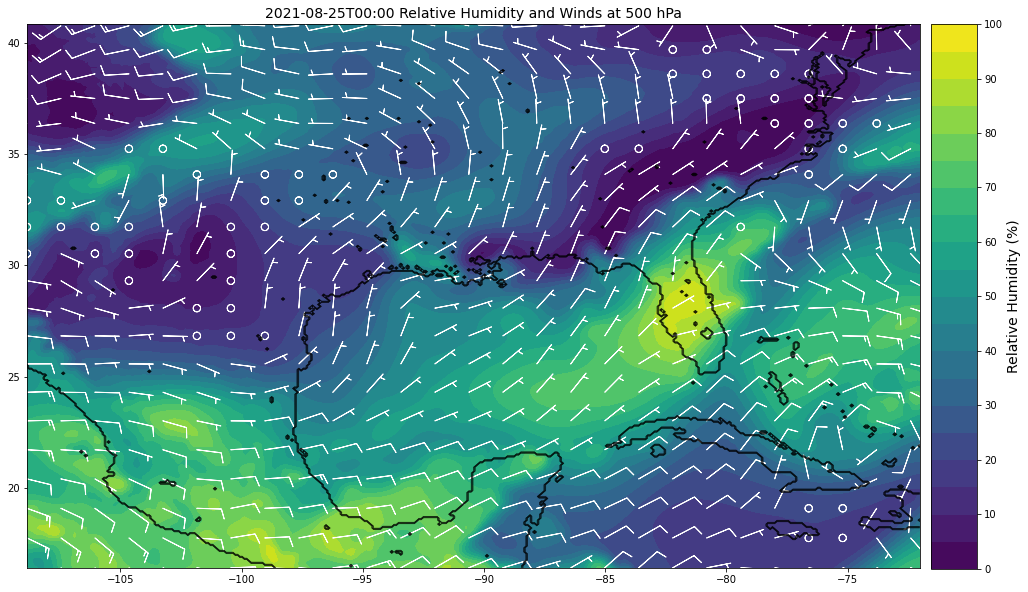

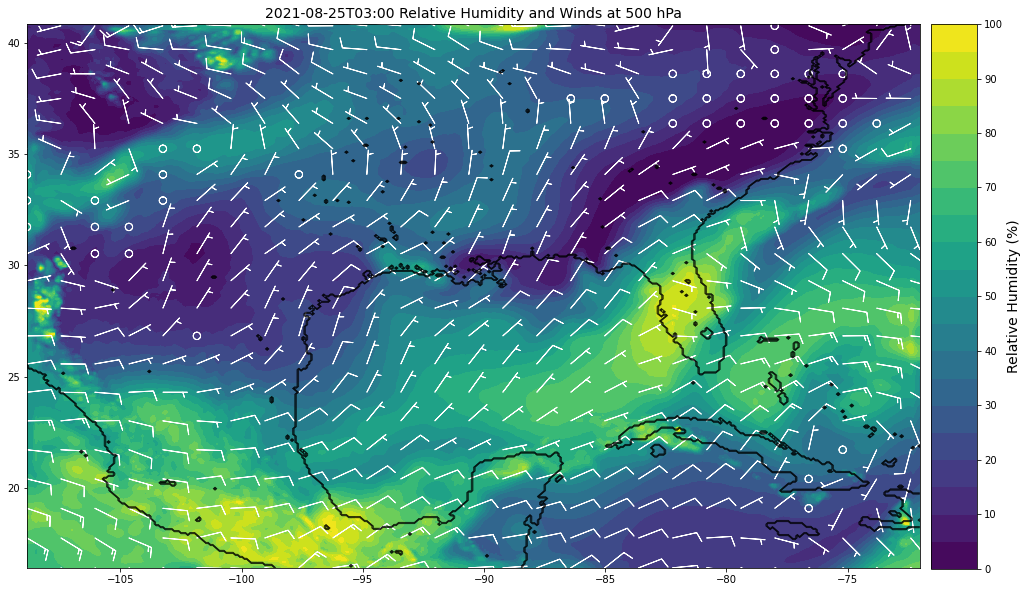

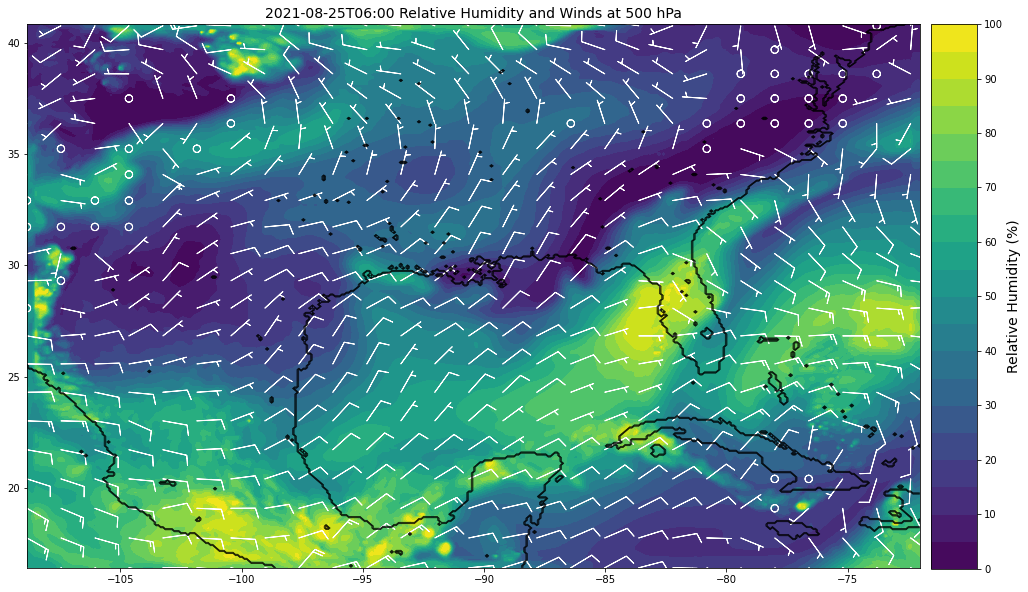

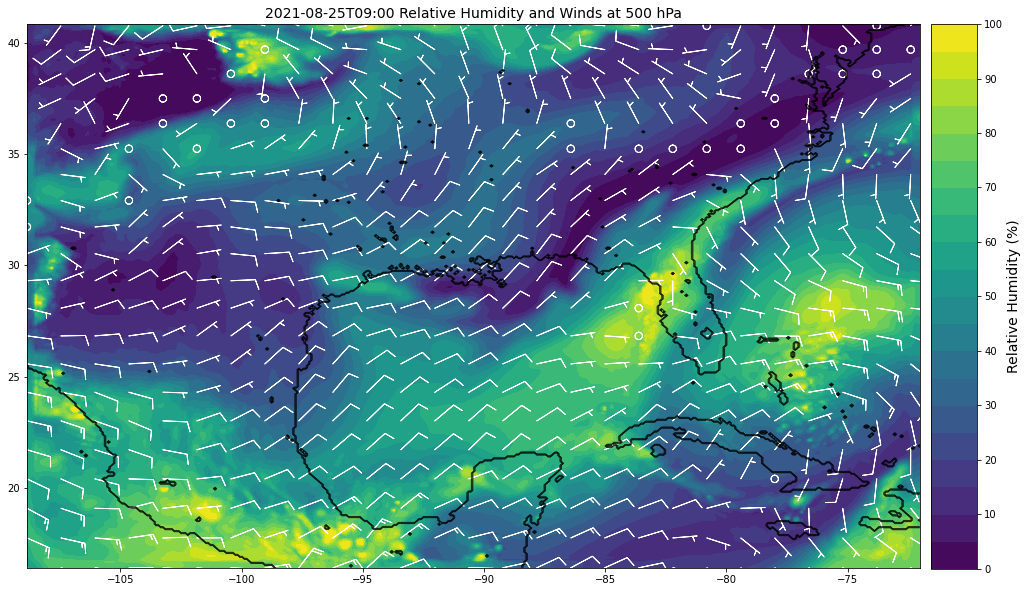

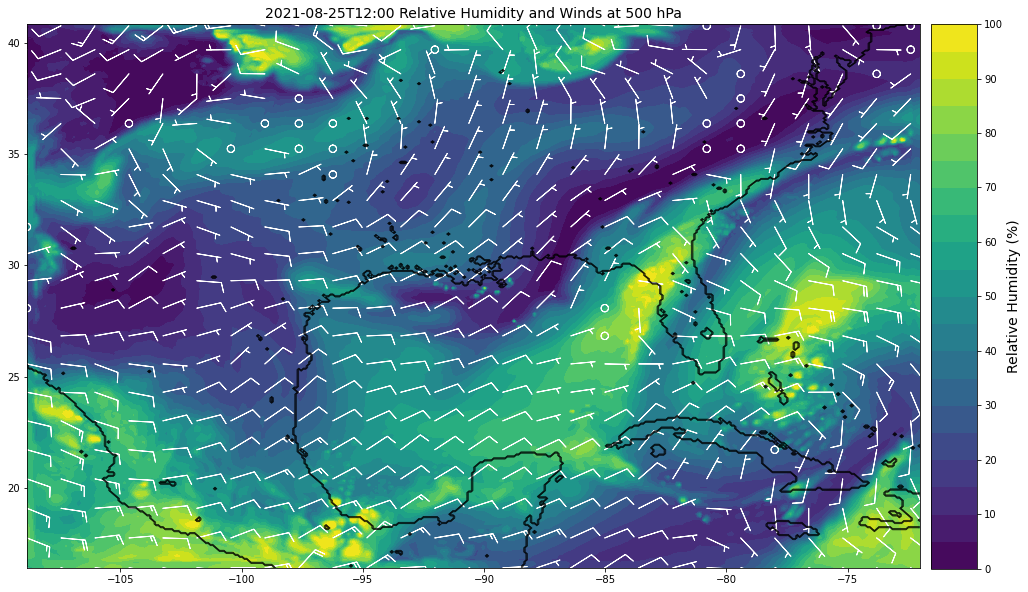

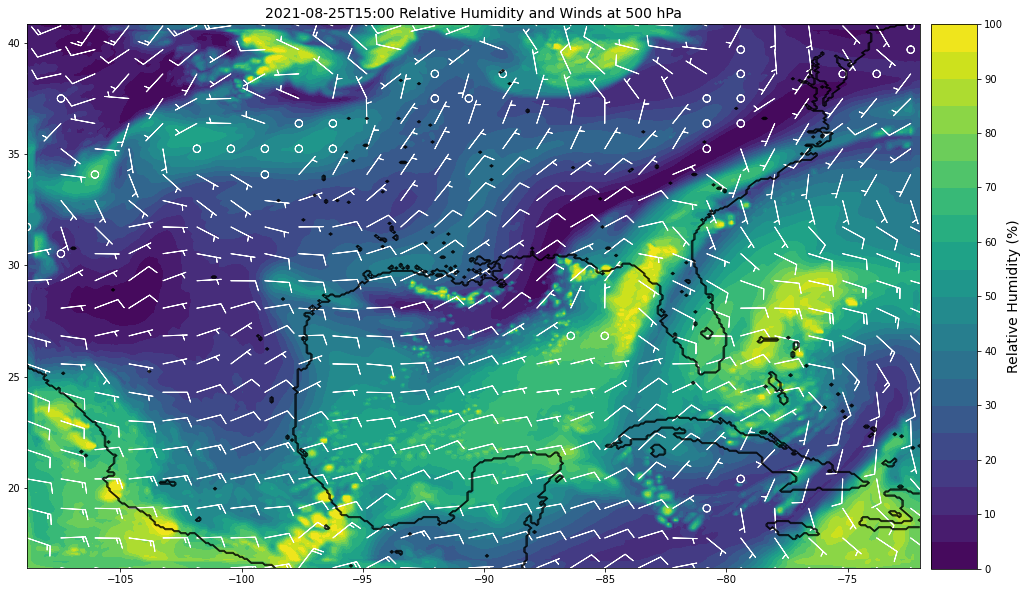

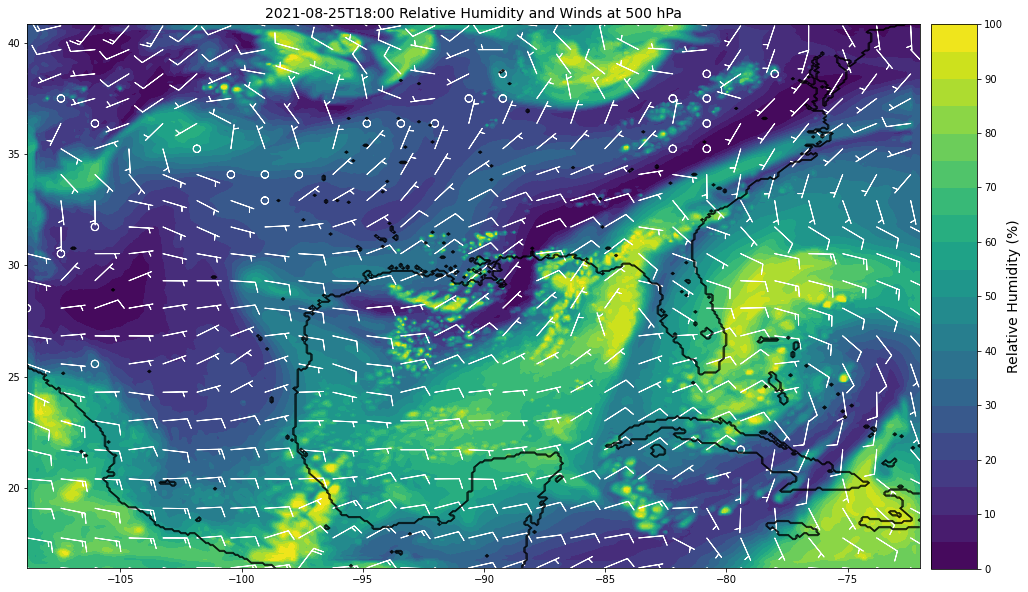

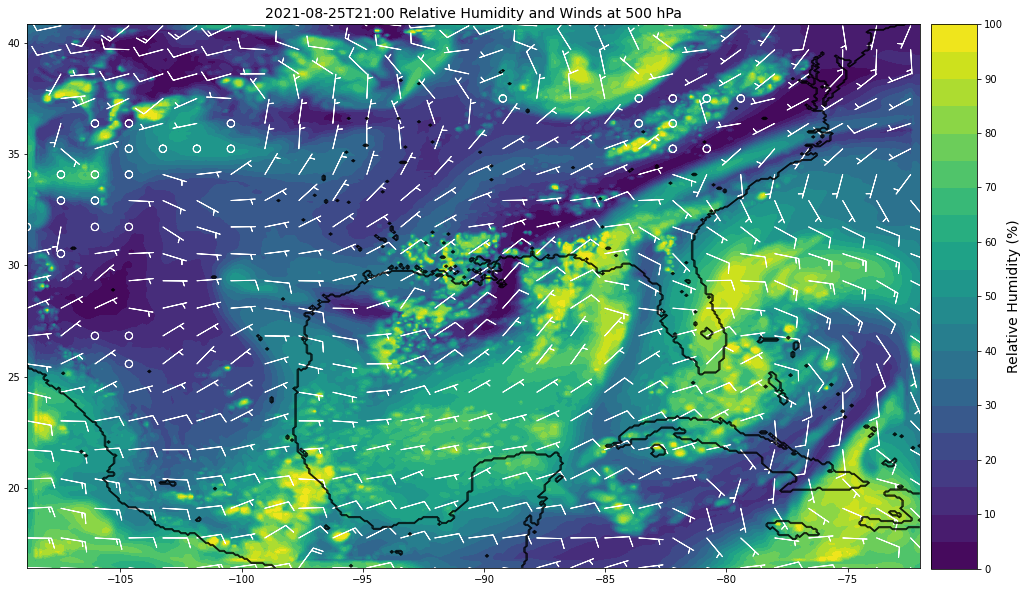

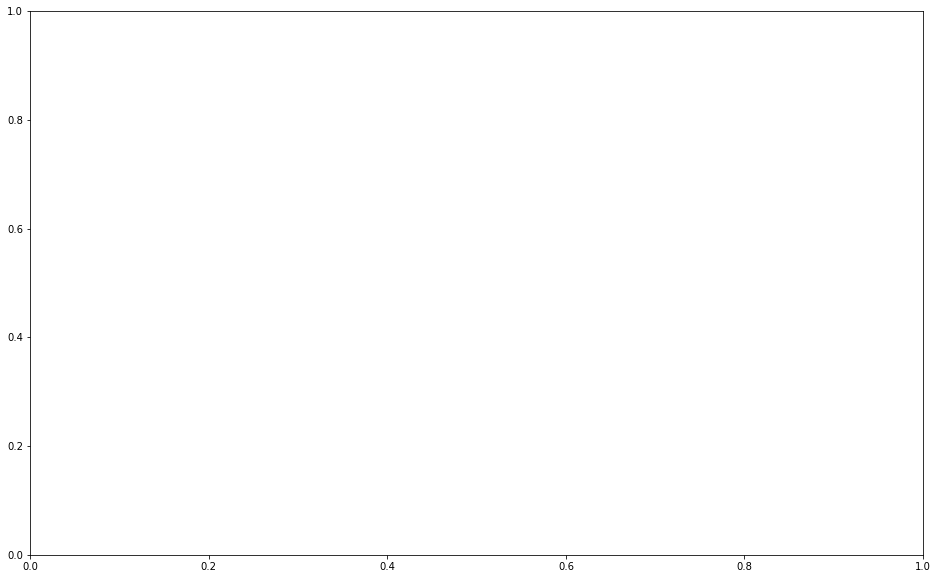

In [14]:
clev = np.arange(0,105,5)
    
for f in WRF_FILES_NWF :
    fig  = plt.figure(figsize=(16,10))
    fig.patch.set_facecolor('white')
    ax   = plt.subplot(111)

    ncfile = netCDF4.Dataset(f,'r')
    xtime  = getvar(ncfile,"Times")
    time_label = str(xtime.values)[0:16]
    LAT = ncfile.variables['XLAT'][:]
    LON = ncfile.variables['XLONG'][:]
    
    P = ncfile.variables['P'][:]
    PB = ncfile.variables['PB'][:]
    PRES = wrf_pres(P,PB)/100. # Divide by 100 to get hPa
    
    THETA = ncfile.variables['T'][:]
    THETA = wrf_theta(THETA)
    TEMP = wrf_temp(THETA,PRES)
    
    WVMIX = ncfile.variables['QVAPOR'][:]
    U = ncfile.variables['U'][:]
    V = ncfile.variables['V'][:]
    W = ncfile.variables['W'][:]
    
    U = wrf_unstagger(U, 'X' )
    V = wrf_unstagger(V, 'Y' )
    W = wrf_unstagger(W, 'Z' )
    
    LM = ncfile.variables['LANDMASK'][:]
    ncfile.close() #Close the file
    
    RH = wrf_rh(TEMP, PRES*100., WVMIX) # Needs to be in Pascals instead of hPa
    RH_ = pres_interp(RH, PRES, PLevels)
    U_ = pres_interp(U, PRES, PLevels)
    V_ = pres_interp(V, PRES, PLevels)
    
    #Contour levels
    #Plot the RH at the specified pressure level and time
    im = ax.contourf(LON[Time_Index], LAT[Time_Index],
                     RH_[Time_Index, Height_Index], clev,
                     cmap=plt.cm.viridis)

    #Add the landmask
    ax.contour(LON[Time_Index], LAT[Time_Index], 
               LM[Time_Index], colors='black', linewidths=0.35)

    #For barbs you may need to fiddle with the sampling frequency depending on your resolution and plot size
    ax.barbs(LON[Time_Index,::xsf,::ysf],
             LAT[Time_Index,::xsf,::ysf],
             U_[Time_Index,Height_Index,::xsf,::ysf],
             V_[Time_Index,Height_Index,::xsf,::ysf],
             color='white')

    #Set the limits based on  min/max lat/lon. May need to modify for southern hemisphere and near the equator
    ax.set_xlim(LON[Time_Index].min(),LON[Time_Index].max())
    ax.set_ylim(LAT[Time_Index].min(),LAT[Time_Index].max())

    #Add the title which will change based on the chosen Plevel
    ax.set_title('%s Relative Humidity and Winds at %s hPa'%(time_label, 
                                           PLevels[Height_Index]), 
                                           fontsize=14)

    #Add the colorbar
    cb_ax = fig.add_axes([.91,.124,.04,.756])
    cbar = fig.colorbar(im, orientation='vertical', cax=cb_ax)
    cbar.set_ticks([0, 10,20,30,40,50,60,70,80,90, 100])
    cbar.set_label('Relative Humidity (%)',size=14)

    #Save the figure  
    plt.savefig("RH_contour_" + time_label + ".png")
    
os.system('convert -quality 92 -delay 12 -loop 0 RH_contour_*png RH_contour.gif')

In [ ]:
os.system('convert -quality 92 -delay 30 -loop 0 RH_contour_*png RH_contour.gif')